# Questions 1-3

In [2]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
%pip install pyspark==3.2.0

%pip install  numpy==1.23.1
# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Retrieving notices: ...working... done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 24.3.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.3.0



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - openjdk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2024.3.11  |       h06a4308_0         127 KB
    certifi-2024.2.2           |  py310h06a4308_0         159 KB
    openjdk-11.0.13            |       h87a67e3_0       341.0 MB
    ------------------------------------------------------------
                                           Total:       341.3 MB

The following NEW packages will be INSTALLED:

  openjdk            pkgs/main/li

In [3]:
# Import pyspark and building Spark session
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    .getOrCreate()
)

print(spark.version)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-4056a8e3-f11b-4c6a-8f2c-524f9f30dd0e;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.2.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.563 in central
:: resolution report :: resolve 375ms :: artifacts dl 32ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.563 from central in [default]
	org.apache.hadoop#hadoop-aws;3.2.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------------------------

3.2.0


In [4]:
import sagemaker
session = sagemaker.Session()
bucket = session.default_bucket()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [5]:
#reading comments
output_prefix_data_comments = "project/comments/yyyy=*"
s3_path = f"s3a://{bucket}/{output_prefix_data_comments}"
comments = spark.read.parquet(s3_path, header=True)

24/04/03 01:31:09 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


In [6]:
#reading submissions
output_prefix_data_submissions = f"project/submissions/yyyy=*"
s3_path = f"s3a://{bucket}/{output_prefix_data_submissions}"
submissions = spark.read.parquet(s3_path, header=True)

24/04/03 01:31:17 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [7]:
comments.printSchema()

root
 |-- author: string (nullable = true)
 |-- author_cakeday: boolean (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- body: string (nullable = true)
 |-- can_gild: boolean (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- edited: string (nullable = true)
 |-- gilded: long (nullable = true)
 |-- id: string (nullable = true)
 |-- is_submitter: boolean (nullable = true)
 |-- link_id: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- permalink: string (nullable = true)
 |-- retrieved_on: timestamp (nullable = true)
 |-- score: long (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)



In [8]:
submissions.printSchema()

root
 |-- adserver_click_url: string (nullable = true)
 |-- adserver_imp_pixel: string (nullable = true)
 |-- archived: boolean (nullable = true)
 |-- author: string (nullable = true)
 |-- author_cakeday: boolean (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- author_id: string (nullable = true)
 |-- brand_safe: boolean (nullable = true)
 |-- contest_mode: boolean (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- crosspost_parent: string (nullable = true)
 |-- crosspost_parent_list: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- approved_at_utc: string (nullable = true)
 |    |    |-- approved_by: string (nullable = true)
 |    |    |-- archived: boolean (nullable = true)
 |    |    |-- author: string (nullable = true)
 |    |    |-- author_flair_css_class: string (nullable = true)
 |    |    |-- author_flair_text: string (nullable = true)
 |    |    

In [12]:
import pyspark.sql.functions as f
import regex as re
import matplotlib.pyplot as plt
import numpy as np

In [11]:
misinfo = comments.withColumn('misinfo_class', 
                    f.when(comments.body.rlike(r'fake news|bullshit|misinfo|clickbait|unreliable|propoganda'), True)\
                    .otherwise(False)).groupBy('misinfo_class').count().toPandas()

In [14]:
misinfo

,misinfo_class,count
0,True,407621
1,False,49562279


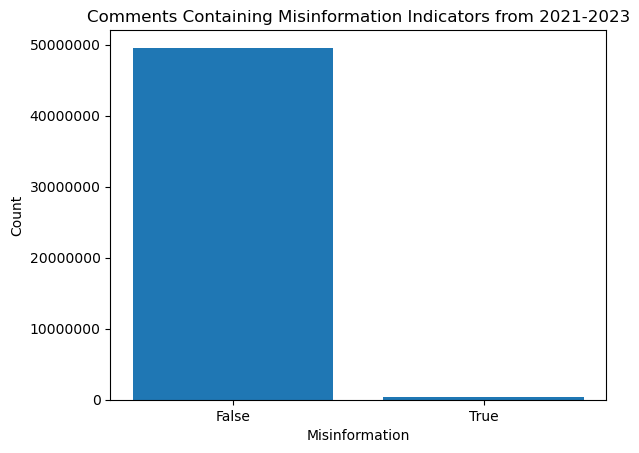

In [28]:
x = [0,1]
mis_class = ['False', 'True']

plt.bar(misinfo['misinfo_class'],misinfo['count'])
plt.ticklabel_format(style='plain')
plt.xlabel("Misinformation")
plt.ylabel("Count")
plt.xticks(x, mis_class)
plt.title("Comments Containing Misinformation Indicators from 2021-2023")
plt.savefig("../data/plots/misinformation.png")

In [13]:
comments_year = comments.withColumn('year', f.year(f.col('created_utc'))).groupBy(['year']).count().toPandas()

In [14]:
comments_year

,year,count
0,2022,27272489
1,2021,19060400
2,2023,3637011


In [20]:
comments_year.to_csv('../data/csv/comments_per_year.csv', index = False)

In [23]:
day_of_week = comments.withColumn('day', f.dayofweek(f.col('created_utc'))).groupBy(['day']).count().toPandas()

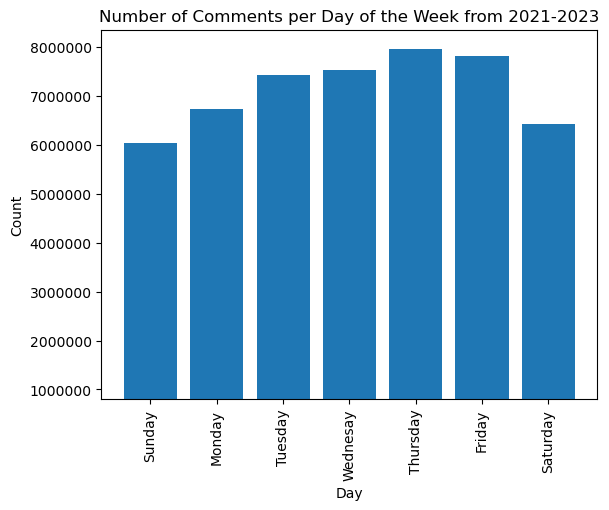

In [27]:
#comments by day
days = ['Sunday','Monday','Tuesday','Wednesay','Thursday','Friday','Saturday']
x = [1,2,3,4,5,6,7]

plt.bar(day_of_week['day'],day_of_week['count'])
plt.ticklabel_format(style='plain')
plt.xlabel("Day")
plt.ylabel("Count")
plt.ylim(800000)
plt.xticks(x, days, rotation='vertical')
plt.title("Number of Comments per Day of the Week from 2021-2023")
plt.savefig("../data/plots/day_of_week.png")

In [15]:
#agg submissions by year
submissions_year = submissions.withColumn('year', f.year(f.col('created_utc'))).groupBy('year').count().toPandas()

In [16]:
submissions_year

,year,count
0,2021,998335
1,2022,732024
2,2023,116779


In [19]:
submissions_year.to_csv('../data/csv//submissions_per_year.csv', index = False)

In [18]:
submissions_day = submissions.withColumn('day', f.dayofweek(f.col('created_utc'))).groupBy('day').count().toPandas()

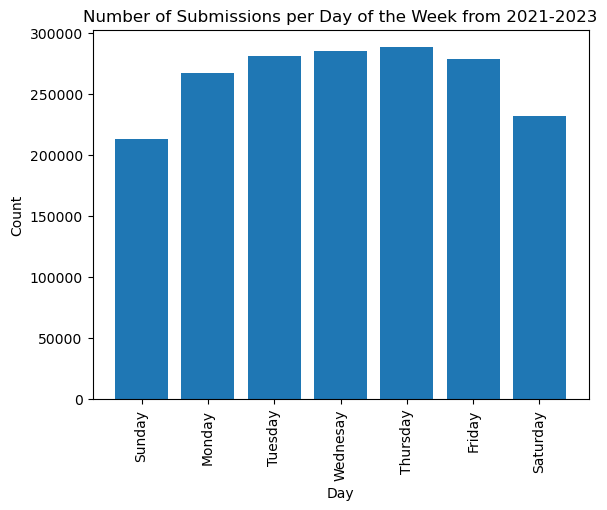

In [24]:
#create submissions per day graph
days = ['Sunday','Monday','Tuesday','Wednesay','Thursday','Friday','Saturday']
x = [1,2,3,4,5,6,7]

plt.bar(submissions_day['day'],submissions_day['count'])
plt.ticklabel_format(style='plain')
plt.xlabel("Day")
plt.ylabel("Count")
plt.xticks(x, days, rotation='vertical')
plt.title("Number of Submissions per Day of the Week from 2021-2023")
plt.savefig("../data/plots/submissions_day.png")

In [11]:
whitelist = submissions.groupBy('whitelist_status').count().toPandas()

In [12]:
whitelist

,whitelist_status,count
0,promo_adult_nsfw,7079
1,all_ads,1407177
2,some_ads,343129
3,no_ads,73039
4,None,16714


In [9]:
hide_score = submissions.groupBy('hide_score').count().toPandas()

In [10]:
hide_score

,hide_score,count
0,True,193
1,False,1846945


In [9]:
score = comments.select('score').summary().toPandas()

In [10]:
score

,summary,score
0,count,49969900
1,mean,16.201878190670783
2,stddev,212.52069814224947
3,min,-3112
4,25%,1
5,50%,1
6,75%,5
7,max,56529


In [21]:
score.to_csv('../data/csv/comments_score.csv', index = False)